## Neural Operator Element Method

In this notebook, we will implement a neural constitutive model. A neural
constitutive model uses neural networks to represent the relationship between
stress and strain in materials. This approach allows for more flexible and
accurate modeling of complex material behaviors compared to traditional
constitutive models.


In [2]:
import jax
import os

jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_enable_x64", True)  # Use double-precision for FEM stability
jax.config.update("jax_platforms", "cpu")  # Change to "gpu" if available

import equinox as eqx
import jax.experimental.sparse as jsp
import jax.numpy as jnp
import numpy as np
import pyvista as pv
import scipy.sparse as sp
import time
from jax import Array
from jax_autovmap import autovmap
from tatva import Mesh, Operator, element, sparse
from tatva_color import distance2_color_and_seeds
from functools import partial

STYLE_PATH = "./latex_sans_serif.mplstyle"


In [3]:
def set_size(fraction=1, height_ratio="golden", width="two-column", subplots=(1, 1)):
    if width == "two-column":
        width_pt = 180  # mm
    elif width == "one-column":
        width_pt = 90  # mm
    else:
        width_pt = width

    if height_ratio == "golden":
        ratio_pt = (np.sqrt(5) - 1.0) / 2.0
    else:
        ratio_pt = height_ratio

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1.0 / 25.4
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * ratio_pt * (subplots[0] / subplots[1])
    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

## Mesh and Material Setup

We start by defining the mesh and material properties for our simulation.


In [5]:
import gmsh
import meshio
import numpy as np
import os


def create_unstructured_3d_through_hole_mesh(
    L=10.0, H=5.0, a=3.0, mesh_size=0.8, filename="noem_3d_hole.msh"
):
    """
    Creates an unstructured tetrahedral mesh for a cuboid with a
    through-hole along the Z-axis.

    Parameters:
    - L: Width/Length of the cuboid (X and Y).
    - H: Height of the cuboid (Z-axis).
    - a: Side of the square hole.
    - mesh_size: Characteristic mesh size.
    """
    gmsh.initialize()
    gmsh.model.add("NOEM_ThroughHole")
    occ = gmsh.model.occ

    outer_vol = occ.addBox(-L / 2, -L / 2, 0, L, L, H)
    cutter_vol = occ.addBox(-a / 2, -a / 2, -0.1, a, a, H + 0.2)

    fem_vol, _ = occ.cut([(3, outer_vol)], [(3, cutter_vol)])
    occ.synchronize()

    all_surfaces = gmsh.model.getEntities(2)
    interface_surfaces = []

    for dim, tag in all_surfaces:
        mass_prop = occ.getCenterOfMass(dim, tag)
        # Check if surface is on the internal walls (x or y = +/- a/2)
        is_internal_x = (
            np.isclose(np.abs(mass_prop[0]), a / 2, atol=1e-3)
            and np.abs(mass_prop[1]) <= a / 2
        )
        is_internal_y = (
            np.isclose(np.abs(mass_prop[1]), a / 2, atol=1e-3)
            and np.abs(mass_prop[0]) <= a / 2
        )
        # Ensure it's not the top or bottom cap of the cuboid
        is_not_cap = not np.isclose(mass_prop[2], 0, atol=1e-3) and not np.isclose(
            mass_prop[2], H, atol=1e-3
        )

        if (is_internal_x or is_internal_y) and is_not_cap:
            interface_surfaces.append(tag)

    gmsh.model.addPhysicalGroup(3, [fem_vol[0][1]], name="FEM_Volume")
    gmsh.model.addPhysicalGroup(2, interface_surfaces, name="Interface")

    gmsh.option.setNumber("Mesh.MeshSizeMin", mesh_size)
    gmsh.option.setNumber("Mesh.MeshSizeMax", mesh_size)
    gmsh.model.mesh.generate(3)
    gmsh.write(filename)
    gmsh.finalize()

    mesh = meshio.read(filename)
    nodes = mesh.points
    fem_elements = mesh.cells_dict["tetra"]

    if "Interface" in mesh.cell_sets_dict:
        # Get the triangles forming the internal boundary
        interface_tris = mesh.cells_dict["triangle"][
            mesh.cell_sets_dict["Interface"]["triangle"]
        ]
        interface_node_ids = np.unique(interface_tris)
    else:
        interface_node_ids = np.unique(mesh.cells_dict["triangle"])

    if os.path.exists(filename):
        os.remove(filename)

    return nodes, fem_elements, interface_node_ids


def get_pyvista_grid(mesh, cell_type="quad"):
    if mesh.coords.shape[1] == 2:
        pv_points = np.hstack((mesh.coords, np.zeros(shape=(mesh.coords.shape[0], 1))))
    else:
        pv_points = np.array(mesh.coords)

    cell_type_dict = {
        "quad": 4,
        "triangle": 3,
        "tetra": 4,
        "hexahedron": 8,
    }

    pv_cells = np.hstack(
        (
            np.full(
                fill_value=cell_type_dict[cell_type], shape=(mesh.elements.shape[0], 1)
            ),
            mesh.elements,
        )
    )

    pv_cell_type_dict = {
        "quad": pv.CellType.QUAD,
        "triangle": pv.CellType.TRIANGLE,
        "tetra": pv.CellType.TETRA,
        "hexahedron": pv.CellType.HEXAHEDRON,
    }
    cell_types = np.full(
        fill_value=pv_cell_type_dict[cell_type], shape=(mesh.elements.shape[0],)
    )

    grid = pv.UnstructuredGrid(pv_cells.flatten(), cell_types, pv_points)

    return grid


a = 3.0
nodes, elements, interface_idx = create_unstructured_3d_through_hole_mesh(
    L=10.0, H=2.0, a=a, mesh_size=0.4
)

mesh = Mesh(coords=nodes, elements=elements)

n_dofs_per_node = 3
n_nodes = mesh.coords.shape[0]
n_dofs = n_dofs_per_node * n_nodes

grid = get_pyvista_grid(mesh, cell_type="tetra")
_ = grid.plot(show_edges=True)


Info    : Meshing 1D...ence - Classify solids                                                                                        
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 40%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 50%] Meshing curve 11 (Line)
Info    : [ 50%] Meshing curve 12 (Line)
Info    : [ 60%] Meshing curve 13 (Line)
Info    : [ 60%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 70%] Meshing curve 16 (Line)
Info    : [ 70%] Meshing curve 17 (Line)
Info    : [ 80%] Meshing curve 18 (Line)
Info    : [ 80%] Meshing curve 19 (Line)
Info    : [ 80%] Meshing curve 20 (Line)
Info    : [ 90%] Meshing curve 21 (Line)
Info    : [ 90

Widget(value='<iframe src="http://localhost:36867/index.html?ui=P_0x7ff04e9dee70_1&reconnect=auto" class="pyvi…

We define a simple 3D bar of length $L$, width $W$, and height $H$. The bar isfixed at one end and subjected to a force at the other end. We use `Tetrahedral` elements for the mesh.


In [6]:
tetra = element.Tetrahedron4()
op = Operator(mesh, tetra)

n_dofs_per_node = 3
n_nodes, n_dofs = mesh.coords.shape[0], mesh.coords.shape[0] * n_dofs_per_node

In [7]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Diffusion coefficient
    lmbda: float  # Diffusion coefficient


E = 1e4
nu = 0.3
mu = E / 2 / (1 + nu)
lmbda = E * nu / (1 - 2 * nu) / (1 + nu)

mat = Material(mu=mu, lmbda=lmbda)


@autovmap(grad_u=2)
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)


@autovmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps, mu, lmbda):
    I = jnp.eye(3)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


@autovmap(grad_u=2, mu=0, lmbda=0)
def strain_energy(grad_u, mu, lmbda):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.einsum("ij,ij->", sigma, eps)


@jax.jit
def total_fem_energy(u_flat: Array) -> float:
    """Compute the total energy of the system."""
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_grad = op.grad(u)
    energy_density = strain_energy(u_grad, mat.mu, mat.lmbda)
    return op.integrate(energy_density)

## Defining the Neural Constitutive Model

The specific architecture employed for the neural strain energy density was a feed-forward Multi-Layer Perceptron (MLP). The network consisted of an input layer accepting the two scalar invariants $(I_1, J)$, followed by two hidden layers with 16 neurons each, and a final output layer producing the scalar
energy value. To ensure that the second-order derivatives (Hessian) remained continuous and numerically stable, a \texttt{softplus} activation function was  utilized across all hidden layers. This choice is critical as standard piecewise linear activations, such as \texttt{ReLU}, yield zero second derivatives almost everywhere, leading to immediate solver divergence.


$$
\psi_{\text{total}}(I_1, J) = \underbrace{\left[ \text{NN}(I_1, J; \theta) - \text{NN}(3, 1; \theta) \right]}_{\text{Shifted Neural Potential}} + \underbrace{\Psi_{\text{base}}(I_1, J)}_{\text{Stiffness Prior}}
$$


In [38]:
class NeuralInclusion(eqx.Module):
    network: eqx.nn.MLP
    stiffness_prior: float  # Helps with initial convergence

    def __init__(self, n_interface_dofs, key, stiffness_prior=1e-2):
        self.stiffness_prior = stiffness_prior
        self.network = eqx.nn.MLP(
            in_size=n_interface_dofs,
            out_size="scalar",
            width_size=64,
            depth=3,
            activation=jax.nn.softplus,  # Must be smooth for Hessian
            key=key,
        )

    def __call__(self, u_interface):
        """
        Computes the shifted energy: G(u) - G(0) + prior
        u_interface: flattened array of displacements for nodes on the boundary
        """
        psi_raw = self.network(u_interface)

        u_zero = jnp.zeros_like(u_interface)
        psi_0 = self.network(u_zero)

        prior = 0.5 * self.stiffness_prior * jnp.sum(u_interface**2)

        return (psi_raw - psi_0) + prior


neural_operator = NeuralInclusion(
    n_interface_dofs=len(interface_idx) * n_dofs_per_node,
    key=jax.random.PRNGKey(0),
    stiffness_prior=1e4, #1e-2
)

Now, we define the neural network architecture and the total strain energy density function based on the neural network defined above.


In [39]:
def total_energy(u_flat, neural_operator):
    u = u_flat.reshape(-1, n_dofs_per_node)
    energy_fem = total_fem_energy(u_flat)

    # Extract displacements for interface nodes
    u_interface = u[interface_idx].flatten()
    energy_neural = neural_operator(u_interface)

    return energy_fem + energy_neural

## Using Coloring to compute Sparse Hessians


In [40]:
sparsity_pattern = sparse.create_sparsity_pattern(mesh, n_dofs_per_node=n_dofs_per_node)
sparsity_pattern_csr = sp.csr_matrix(
    (
        sparsity_pattern.data,
        (sparsity_pattern.indices[:, 0], sparsity_pattern.indices[:, 1]),
    )
)
indptr = sparsity_pattern_csr.indptr
indices = sparsity_pattern_csr.indices
colors = sparse.distance2_colors(
    row_ptr=sparsity_pattern_csr.indptr,
    col_idx=sparsity_pattern_csr.indices,
    n_dofs=n_dofs,
)

# Closure for the energy based on the NN weights
energy_fn = eqx.Partial(total_energy, neural_operator=neural_operator)
gradient_fn = jax.jacrev(energy_fn)

K_sparse_fn = sparse.jacfwd_with_batch(
    gradient=gradient_fn,
    row_ptr=jnp.array(sparsity_pattern_csr.indptr),
    col_indices=jnp.array(sparsity_pattern_csr.indices),
    colors=jnp.array(colors),
    color_batch_size=mesh.elements.shape[0],
)

To check if the total energy at 0 deformation is zero, we can evaluate the total strain energy density function at the reference configuration where $I_1 = 3$ and $J = 1$. This ensures that the neural network's contribution is shifted  appropriately, and the stiffness prior is also evaluated at this point.


## Applying Boundary Conditions and Loads


In [41]:
# Boundary Conditions & Solver Setup
y_min, y_max = jnp.min(mesh.coords[:, 1]), jnp.max(mesh.coords[:, 1])


top_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_max))[0]
bottom_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_min))[0]

applied_dofs = n_dofs_per_node * top_nodes + 1  # y-direction DOFs at the top nodes

zero_dofs = jnp.concatenate(
    [n_dofs_per_node * bottom_nodes, n_dofs_per_node * bottom_nodes + 1]
)

fixed_dofs = jnp.concatenate([applied_dofs, zero_dofs])

prescribed_values = jnp.zeros(n_dofs).at[applied_dofs].set(1.0)

zero_indices, one_indices = sparse.get_bc_indices(sparsity_pattern, fixed_dofs)

## Defining Newton Solver


In [42]:
@eqx.filter_jit
def newton_sparse_solver(
    u,
    fext,
    gradient,
    hessian_sparse,
    fixed_dofs,
    zero_indices,
    one_indices,
    indptr,
    indices,
):
    fint = gradient(u)

    norm_res = 1.0

    tol = 1e-8
    max_iter = 10

    def solver(u, n):
        def true_func(u):
            fint = gradient(u)
            residual = fext - fint
            residual = residual.at[fixed_dofs].set(0.0)

            K_sparse = hessian_sparse(u)
            K_data_lifted = K_sparse.data.at[zero_indices].set(0)
            K_data_lifted = K_data_lifted.at[one_indices].set(1)

            du = jsp.linalg.spsolve(
                K_data_lifted, indices=indices, indptr=indptr, b=residual
            )

            u = u.at[:].add(du)
            return u

        def false_func(u):
            return u

        fint = gradient(u)
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0.0)
        norm_res = jnp.linalg.norm(residual)

        jax.debug.print("residual={}", norm_res)

        return jax.lax.cond(norm_res > tol, true_func, false_func, u), n

    u, xs = jax.lax.scan(solver, init=u, xs=jnp.arange(0, max_iter))

    fint = gradient(u)
    residual = fext - fint
    residual = residual.at[fixed_dofs].set(0.0)
    norm_res = jnp.linalg.norm(residual)

    return u, norm_res

## Solving the System


In [43]:
u_prev = jnp.zeros(n_dofs)

fext = jnp.zeros(n_dofs) 

n_steps = 5
applied_displacement = prescribed_values / n_steps  # displacement increment

residual_history = []

print("Starting Neural Constitutive Solver...")
for i in range(n_steps):  # Newton iterations
    u_prev = u_prev.at[fixed_dofs].add(applied_displacement[fixed_dofs])

    u_new, rnorm = newton_sparse_solver(
        u_prev,
        fext,
        gradient_fn,
        K_sparse_fn,
        fixed_dofs,
        zero_indices,
        one_indices,
        indptr,
        indices,
    )

    residual_history.append(rnorm)

    u_prev = u_new

    print(f"Iteration {i}: Residual Norm = {rnorm:.4e}")

u_sol = u_prev.reshape(n_nodes, n_dofs_per_node)

Starting Neural Constitutive Solver...
residual=12808.14011061805
residual=1.2741304941232856e-05
residual=4.668291117444495e-12
residual=4.668291117444495e-12
residual=4.668291117444495e-12
residual=4.668291117444495e-12
residual=4.668291117444495e-12
residual=4.668291117444495e-12
residual=4.668291117444495e-12
residual=4.668291117444495e-12
Iteration 0: Residual Norm = 4.6575e-12
residual=12808.140110612276
residual=1.2741216160346438e-05
residual=9.46502669290623e-12
residual=9.46502669290623e-12
residual=9.46502669290623e-12
residual=9.46502669290623e-12
residual=9.46502669290623e-12
residual=9.46502669290623e-12
residual=9.46502669290623e-12
residual=9.46502669290623e-12
Iteration 1: Residual Norm = 9.4721e-12
residual=12808.14011061228
residual=1.2741272634583138e-05
residual=1.4824911525406877e-11
residual=1.4824911525406877e-11
residual=1.4824911525406877e-11
residual=1.4824911525406877e-11
residual=1.4824911525406877e-11
residual=1.4824911525406877e-11
residual=1.482491152540

In [15]:
pv.global_theme.transparent_background = True

highlight_coords = mesh.coords[interface_idx]

points_to_highlight = pv.PolyData(np.array(highlight_coords))

grid = pv.UnstructuredGrid(
    np.hstack((np.full((mesh.elements.shape[0], 1), 4), mesh.elements)).flatten(),
    np.full(mesh.elements.shape[0], pv.CellType.TETRA),
    np.array(mesh.coords),
)

# Compute fields
grid["u_mag"] = np.linalg.norm(u_sol, axis=1)
grid["u_vec"] = np.array(u_sol)
grad_u = op.grad(u_sol).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)
grid["sigma_yy"] = stresses[:, 1, 1].flatten()

warped = grid.warp_by_vector("u_vec", factor=4.0)

width_mm = 220
dpi = 300
width_px = int((width_mm / 25.4) * dpi)
height_px = int(width_px * 0.4)  # Adjust height ratio for 3 subplots

pl = pv.Plotter() 

pl.add_mesh(grid, show_edges=True, color="lightgray", edge_color="gray", line_width=0.5)
pl.add_mesh(
    points_to_highlight,
    color="red",
    point_size=10.0,
    render_points_as_spheres=True,
    label="Boundary Nodes",
)
pl.view_vector([-0.55, -0.65, 0.5])

pl.view_isometric()
pl.save_graphic("../figures/neural_inclusion_original_mesh.svg")
pl.screenshot("../figures/neural_inclusion_original_mesh.png", transparent_background=True)
pl.show()

Widget(value='<iframe src="http://localhost:36867/index.html?ui=P_0x7fefe4133890_3&reconnect=auto" class="pyvi…

In [44]:
grid = pv.UnstructuredGrid(
    np.hstack((np.full((mesh.elements.shape[0], 1), 4), mesh.elements)).flatten(),
    np.full(mesh.elements.shape[0], pv.CellType.TETRA),
    np.array(mesh.coords),
)

pl = pv.Plotter()

grad_u = op.grad(u_sol).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)


grid["u"] = np.array(u_sol)
grid["sigma_yy"] = stresses[:, 1, 1].flatten()

warped = grid.warp_by_vector("u", factor=4.0)
pl.add_mesh(warped, show_edges=False, scalars="u", cmap="managua", show_scalar_bar=False)
pl.view_isometric()
pl.save_graphic("../figures/neural_soft_inclusion_deformed_mesh.svg")
pl.screenshot("../figures/neural_soft_inclusion_deformed_mesh.png", transparent_background=True)
pl.show()

Widget(value='<iframe src="http://localhost:36867/index.html?ui=P_0x7fefc6ce21e0_7&reconnect=auto" class="pyvi…

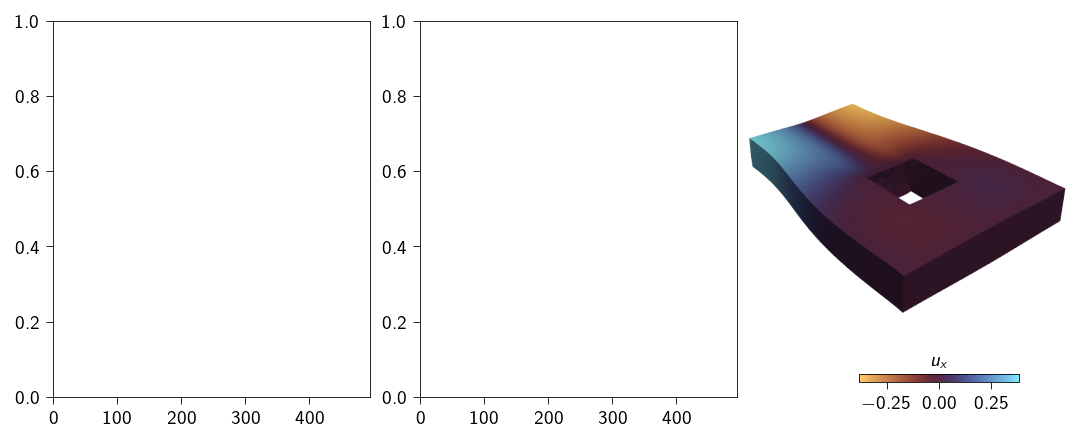

Vector-hybrid SVG saved to: ../figures/grid_render_hard_neural.svg


In [45]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt


def set_size(fraction=1, height_ratio='golden', width='two-column', subplots=(1, 1)):
    if width == 'two-column':
        width_pt = 180 # mm
    elif width == 'one-column':
        width_pt = 90 # mm
    else:
        width_pt = width

    if height_ratio == 'golden':
        ratio_pt = (np.sqrt(5) - 1.0) / 2.0
    else:
        ratio_pt = height_ratio
        
    fig_width_pt = width_pt * fraction
    inches_per_pt = 1.0 / 25.4
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * ratio_pt * (subplots[0]/subplots[1])
    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

def get_render_and_colorbar(grid, sub_dim_in, dpi, step_idx=0, vmin=None, vmax=None):
    
    px_w, px_h = int(sub_dim_in[0] * dpi), int(sub_dim_in[1] * dpi)
  
    pl = pv.Plotter(off_screen=True, window_size=[px_w, px_h])
    pl.set_background("white")
    pl.add_mesh(grid, scalars="u", component=0, cmap="managua", show_scalar_bar=False, smooth_shading=False)

    pl.view_vector([-0.55, -0.65, 0.5])
    
    render_raw = Image.fromarray(pl.screenshot(None, return_img=True, transparent_background=True))
    img_3d = render_raw.crop(render_raw.getbbox())
    pl.close()

    c_min, c_max = np.min(grid.point_data["u"][:, 0]), np.max(grid.point_data["u"][:, 0])
    cb_artist = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=c_min, vmax=c_max), cmap="managua")
    
    return img_3d, cb_artist


def generate_grid_svg(mesh, ax_id=0, subplots=(1, 3), filename="../figures/grid_render_hard_neural.svg"):
    width_ratios = [1, 1, 1]

    fig_dim_in = set_size(subplots=subplots, height_ratio=0.6) 
    plt.style.use("./latex_sans_serif.mplstyle")

    fig, axs = plt.subplots(1, subplots[1], figsize=fig_dim_in, layout='constrained', gridspec_kw={'width_ratios': width_ratios}, sharex=True)

    img_3d, cb = get_render_and_colorbar(mesh, 
                                        (fig_dim_in[0]/subplots[1] * width_ratios[ax_id], fig_dim_in[1]/subplots[0]), 
                                        dpi=400, )
        
    axs[ax_id].imshow(img_3d)
    axs[ax_id].axis('off')

    cax = fig.add_axes([0.8, 0.12, 0.15, 0.02])
    cb = fig.colorbar(cb, cax=cax, orientation='horizontal', label=r"$u_x$", pad=0.01)
    cb.ax.xaxis.set_label_position("top")
    axs[ax_id].set_axis_off()


    plt.savefig(filename, format='svg', bbox_inches='tight', transparent=True)
    plt.savefig(filename.replace('.svg', '.pdf'), format='pdf',  bbox_inches='tight', transparent=True)
    plt.savefig(filename.replace('.svg', '.png'), format='png', dpi=300,  bbox_inches='tight', transparent=True)
    plt.show()
    plt.close(fig)

    print(f"Vector-hybrid SVG saved to: {filename}")


generate_grid_svg(warped, ax_id=2, subplots=(2, 3))